In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [24]:
stk_list = pd.read_csv("data/stock_list.csv")
stk_list = stk_list[~stk_list['industry_category'].isin(['ETF','ETN','上櫃指數股票型基金(ETF)','受益證券','指數投資證券(ETN)','其他','所有證券','創新板股票','存託憑證', 'Index', '大盤'])]
stk_list = stk_list[stk_list['type'].isin(['twse'])]
stk_list = stk_list[stk_list['stock_id'].apply(lambda x: len(x) == 4)]
stk_list

,industry_category,stock_id,stock_name,type,date
355,水泥工業,1101,台泥,twse,2023-12-14
357,水泥工業,1102,亞泥,twse,2023-12-14
358,水泥工業,1103,嘉泥,twse,2023-12-14
359,水泥工業,1104,環泥,twse,2023-12-14
361,水泥工業,1108,幸福,twse,2023-12-14
...,...,...,...,...,...
3165,觀光事業,9943,好樂迪,twse,2023-06-29
3166,觀光餐旅,9943,好樂迪,twse,2023-12-14
3169,建材營造,9946,三發地產,twse,2023-12-14
3174,綠能環保,9955,佳龍,twse,2023-12-14


In [25]:
stock_ids = stk_list['stock_id'].unique()

#load data
df_trading = pd.read_csv('data/all_stock_close_price_from2022-12-23to2023-12-24.csv')
df_broker = pd.read_csv('data/9217_from2022-12-23to2023-12-24_trader_trading.csv')

# 過濾出要分析的股票 而不是ETF等等
df_broker = df_broker[df_broker['stock_id'].isin(stock_ids)]

# 按日期分組，選取每天買進量前二十的股票
# top20_buys_daily = df_broker.groupby('date').apply(lambda x: x.sort_values('buy', ascending=False).head(20)).reset_index(drop=True)

buys_daily = df_broker.groupby('date').apply(lambda x: x.sort_values('buy', ascending=False)).reset_index(drop=True)


# 計算每支股票每天的總買進量
broker_buy_sum = buys_daily.groupby(['stock_id', 'date'])['buy'].sum().reset_index()

# 合併到每日成交資料中
df_combined = pd.merge(df_trading, broker_buy_sum, on=['stock_id', 'date'], how='left')


# 計算買進比例
df_combined['buy_ratio'] = df_combined['buy'] / df_combined['Trading_Volume']

In [37]:
# 對日期進行排序，以便計算隔天價格
df_combined.sort_values(by=['stock_id', 'date'], inplace=True)

# 計算隔天的股價變化
df_combined['next_day_close'] = df_combined.groupby('stock_id')['close'].shift(-1)
df_combined['price_change'] = df_combined['next_day_close'] - df_combined['close']
df_combined['price_change_percentage'] = (df_combined['price_change'] / df_combined['close']) * 100

#list the next_day_price_change > +- 10%
df_outlier = df_combined[df_combined['price_change_percentage'].apply(lambda x: abs(x) > 10)]
df_outlier


,date,stock_id,Trading_Volume,Trading_money,open,max,min,close,spread,Trading_turnover,...,next_day_close,price_change,price_change_percentage,price_change_next_day,price_change_day_2,price_change_day_3,price_change_day_4,price_change_day_5,avg_price_change_5d,price_change_10
832501,2023-02-10,1103,154329,2853218,18.50,18.55,18.40,18.55,0.00,143,...,21.15,2.60,14.016173,14.016173,12.129380,11.859838,12.398922,9.973046,11.590296,1.0
4147267,2023-07-12,1104,1154071,34719734,30.00,30.25,29.90,30.15,0.25,733,...,27.10,-3.05,-10.116086,-10.116086,-1.824212,-3.814262,-1.492537,-3.150912,-2.570481,0.0
552792,2023-01-30,1201,276281,5257638,19.00,19.10,18.95,19.00,0.05,411,...,21.00,2.00,10.526316,10.526316,11.315789,9.473684,8.157895,5.526316,8.618421,1.0
492168,2023-01-16,1219,789743,14945903,19.00,19.00,18.85,18.90,0.00,253,...,20.90,2.00,10.582011,10.582011,14.021164,18.518519,20.105820,18.783069,17.857143,1.0
2260319,2023-04-21,1310,7655318,117253233,14.85,15.55,14.70,15.50,0.65,2926,...,17.05,1.55,10.000000,10.000000,6.451613,14.193548,10.967742,10.645161,10.564516,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6166750,2023-09-27,9946,84177,1232427,14.65,14.70,14.60,14.70,0.00,56,...,17.30,2.60,17.687075,17.687075,17.687075,16.326531,17.006803,17.687075,17.176871,1.0
31644,2022-12-23,9955,629849,13025175,21.15,21.25,20.35,20.55,-0.65,453,...,23.10,2.55,12.408759,12.408759,7.785888,3.406326,7.055961,0.486618,4.683698,1.0
6369906,2023-10-05,9955,131016,2756641,20.95,21.15,20.95,21.05,0.10,120,...,24.80,3.75,17.814727,17.814727,20.665083,24.228029,33.254157,33.254157,27.850356,1.0
4341126,2023-07-19,9958,8250723,1177742062,143.50,145.50,138.50,142.50,1.00,3616,...,158.50,16.00,11.228070,11.228070,15.438596,15.087719,14.736842,16.140351,15.350877,1.0


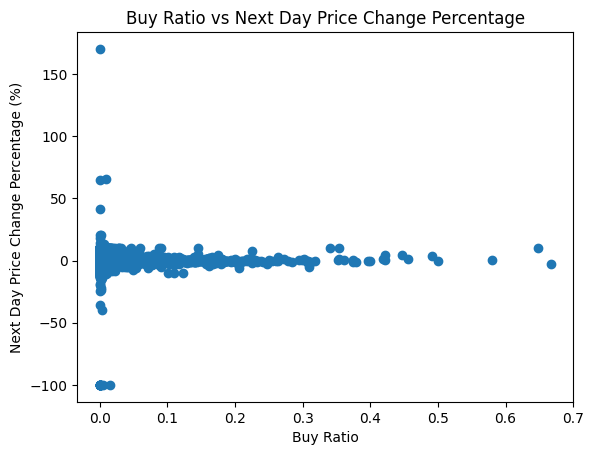

In [27]:
# 繪製散點圖
plt.scatter(df_combined['buy_ratio'], df_combined['price_change_percentage'])

# 隨機選擇部分點進行標注
sampled_points = df_combined.sample(n=20)
for index, row in sampled_points.iterrows():
    plt.annotate(f"{row['stock_id']} ({row['date']}, {row['price_change_percentage']:.2f}%)",
                 (row['buy_ratio'], row['price_change_percentage']))

plt.xlabel('Buy Ratio')
plt.ylabel('Next Day Price Change Percentage (%)')
plt.title('Buy Ratio vs Next Day Price Change Percentage')
plt.show()

True
True


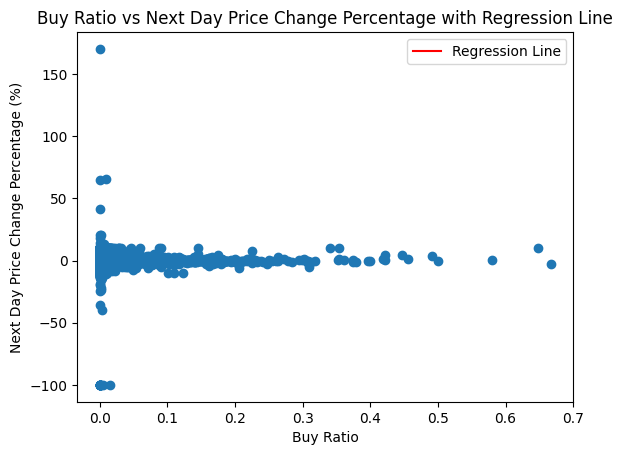

In [28]:

print(df_combined['buy_ratio'].isnull().any())
print(df_combined['price_change_percentage'].isnull().any())

# 移除NaN值
df_combined = df_combined.dropna(subset=['buy_ratio', 'price_change_percentage'])
# 使用numpy計算線性回歸的參數
slope, intercept = np.polyfit(df_combined['buy_ratio'], df_combined['price_change_percentage'], 1)


# 移除NaN值
df_combined = df_combined.dropna(subset=['buy_ratio', 'price_change_percentage'])
# 繪製散點圖
plt.scatter(df_combined['buy_ratio'], df_combined['price_change_percentage'])

# 繪製回歸線
x = np.array(df_combined['buy_ratio'])
plt.plot(x, intercept + slope * x, color='red', label='Regression Line')

# 添加標籤和標題
plt.xlabel('Buy Ratio')
plt.ylabel('Next Day Price Change Percentage (%)')
plt.title('Buy Ratio vs Next Day Price Change Percentage with Regression Line')
plt.legend()

# 顯示圖形
plt.show()


In [29]:
# 改追蹤接下來五天的股價變化
# 對日期進行排序，以便計算隔天價格
df_combined.sort_values(by=['stock_id', 'date'], inplace=True)

# 計算隔天及後續四天的股價變化
df_combined['next_day_close'] = df_combined.groupby('stock_id')['close'].shift(-1)
df_combined['price_change_next_day'] = (df_combined['next_day_close'] - df_combined['close']) / df_combined['close'] * 100

for i in range(2, 6):
    df_combined[f'price_change_day_{i}'] = (df_combined.groupby('stock_id')['close'].shift(-i) - df_combined['close']) / df_combined['close'] * 100




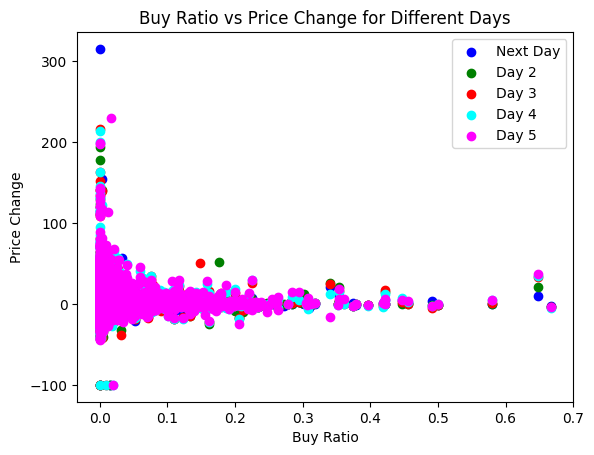

In [30]:
# 繪製散點圖
plt.scatter(df_combined['buy_ratio'], df_combined['price_change_next_day'], color='blue', label='Next Day')
plt.scatter(df_combined['buy_ratio'], df_combined['price_change_day_2'], color='green', label='Day 2')
plt.scatter(df_combined['buy_ratio'], df_combined['price_change_day_3'], color='red', label='Day 3')
plt.scatter(df_combined['buy_ratio'], df_combined['price_change_day_4'], color='cyan', label='Day 4')
plt.scatter(df_combined['buy_ratio'], df_combined['price_change_day_5'], color='magenta', label='Day 5')

# 添加標籤和標題
plt.xlabel('Buy Ratio')
plt.ylabel('Price Change')
plt.title('Buy Ratio vs Price Change for Different Days')
plt.legend()

# 顯示圖形
plt.show()

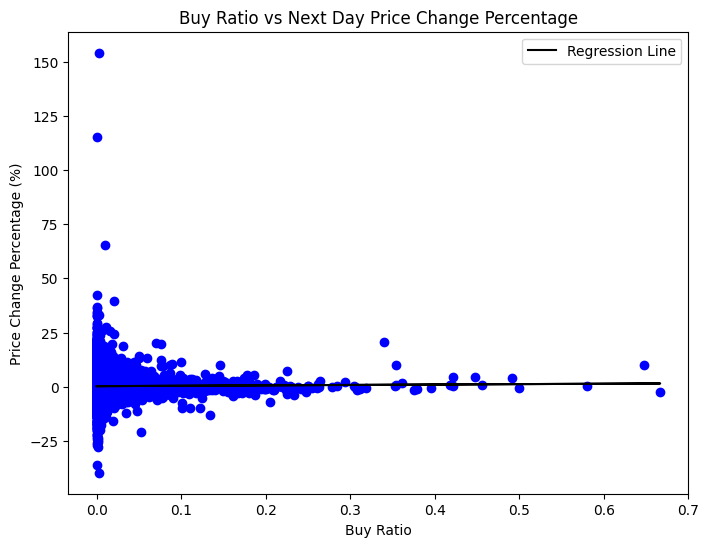

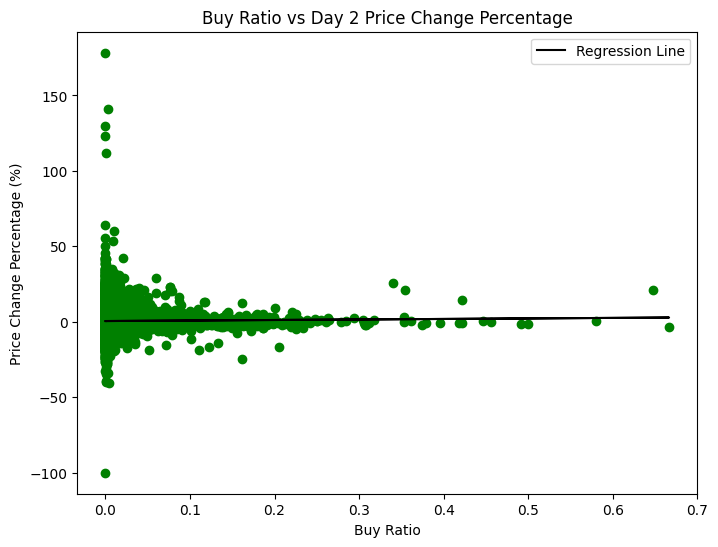

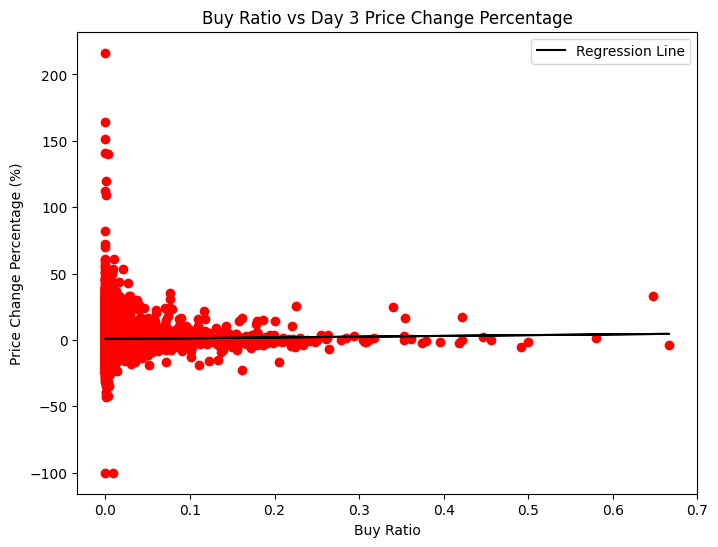

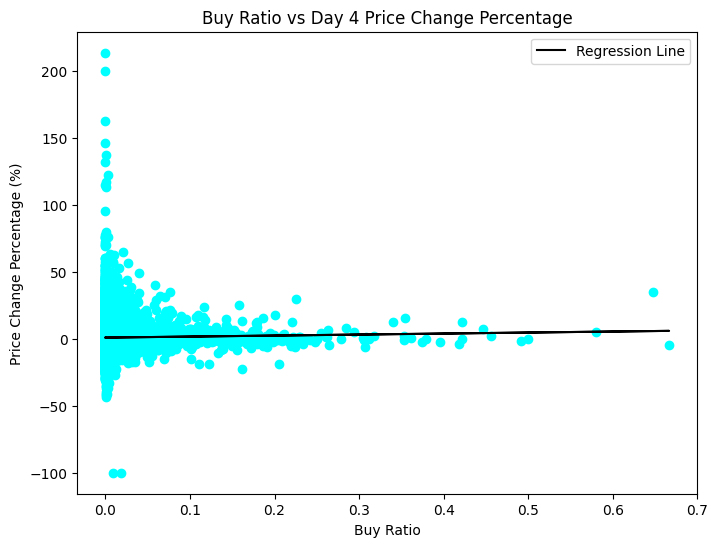

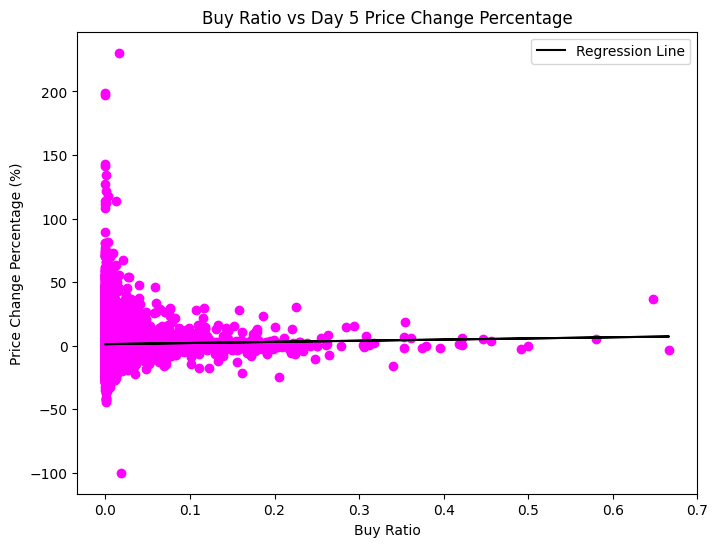

In [31]:
# 計算回歸線參數並繪製散點圖及回歸線的函數
def plot_with_regression(x, y, title, color):
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, color=color)

    # 計算回歸線參數
    slope, intercept = np.polyfit(x, y, 1)
    plt.plot(x, slope * x + intercept, color='black', label='Regression Line')

    plt.xlabel('Buy Ratio')
    plt.ylabel('Price Change Percentage (%)')
    plt.title(title)
    plt.legend()
    plt.show()

# 去除含有NaN值的行
df_combined.dropna(subset=['price_change_next_day', 'price_change_day_2', 'price_change_day_3', 'price_change_day_4', 'price_change_day_5'], inplace=True)

# 繪製每一天的散點圖和回歸線
plot_with_regression(df_combined['buy_ratio'], df_combined['price_change_next_day'], 'Buy Ratio vs Next Day Price Change Percentage', 'blue')
plot_with_regression(df_combined['buy_ratio'], df_combined['price_change_day_2'], 'Buy Ratio vs Day 2 Price Change Percentage', 'green')
plot_with_regression(df_combined['buy_ratio'], df_combined['price_change_day_3'], 'Buy Ratio vs Day 3 Price Change Percentage', 'red')
plot_with_regression(df_combined['buy_ratio'], df_combined['price_change_day_4'], 'Buy Ratio vs Day 4 Price Change Percentage', 'cyan')
plot_with_regression(df_combined['buy_ratio'], df_combined['price_change_day_5'], 'Buy Ratio vs Day 5 Price Change Percentage', 'magenta')

零假設（H0）是：當券商買進量佔當天總成交量的1%以上時，對該股票接下來五天的平均股價沒有顯著影響

In [32]:
df_combined['avg_price_change_5d'] = df_combined[['price_change_day_2', 'price_change_day_3', 'price_change_day_4', 'price_change_day_5']].mean(axis=1)


# 使用.loc[]來避免SettingWithCopyWarning
df_high_buy = df_combined[df_combined['buy_ratio'] >= 0.01].copy()
df_high_buy.loc[:, 'avg_price_change_5d'] = (df_high_buy[['price_change_day_2', 'price_change_day_3', 'price_change_day_4', 'price_change_day_5']].sum(axis=1)) / 4
df_combined

,date,stock_id,Trading_Volume,Trading_money,open,max,min,close,spread,Trading_turnover,...,buy_ratio,next_day_close,price_change,price_change_percentage,price_change_next_day,price_change_day_2,price_change_day_3,price_change_day_4,price_change_day_5,avg_price_change_5d
23295,2022-12-23,1101,23483856,804299895,34.15,34.60,33.80,34.05,-0.40,10819,...,0.000554,34.40,0.35,1.027900,1.027900,0.734214,0.734214,-1.027900,-1.174743,-0.183554
54972,2022-12-26,1101,12361474,424140679,34.35,34.45,34.10,34.40,0.35,5761,...,0.000243,34.30,-0.10,-0.290698,-0.290698,-0.290698,-2.034884,-2.180233,-2.616279,-1.780523
86644,2022-12-27,1101,11426803,394169733,34.55,34.70,34.30,34.30,-0.10,6494,...,0.000175,34.30,0.00,0.000000,0.000000,-1.749271,-1.895044,-2.332362,-2.332362,-2.077259
118300,2022-12-28,1101,14092727,482086632,34.15,34.35,33.95,34.30,0.00,5921,...,0.000142,33.70,-0.60,-1.749271,-1.749271,-1.895044,-2.332362,-2.332362,0.437318,-1.530612
150025,2022-12-29,1101,13483783,456027492,34.25,34.25,33.70,33.70,-0.60,6848,...,0.000519,33.65,-0.05,-0.148368,-0.148368,-0.593472,-0.593472,2.225519,1.632047,0.667656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8194781,2023-12-08,9958,5615336,1026727125,183.00,185.00,180.00,182.50,0.50,3979,...,0.000000,179.00,-3.50,-1.917808,-1.917808,-0.821918,-1.369863,2.191781,-5.753425,-1.438356
8237047,2023-12-11,9958,5627796,1005647950,183.00,183.50,176.00,179.00,-3.50,10760,...,0.000560,181.00,2.00,1.117318,1.117318,0.558659,4.189944,-3.910615,1.396648,0.558659
8279448,2023-12-12,9958,4877111,887945491,179.50,184.50,179.50,181.00,2.00,3683,...,0.000000,180.00,-1.00,-0.552486,-0.552486,3.038674,-4.972376,0.276243,0.276243,-0.345304
8321959,2023-12-13,9958,5062733,925013081,183.00,185.50,180.00,180.00,-1.00,8060,...,0.000198,186.50,6.50,3.611111,3.611111,-4.444444,0.833333,0.833333,-1.111111,-0.972222


In [33]:
from scipy import stats

# 提取兩組數據：買進比例大於等於1%的樣本和所有樣本
group1 = df_high_buy['avg_price_change_5d']
group2 = df_combined['avg_price_change_5d']

# 列出樣本數
group1_count = len(group1)
group2_count = len(group2)
print("買進比例大於等於1%的樣本數:", group1_count)
print("所有樣本數:", group2_count)

# 進行t檢定
t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)

print("t統計量:", t_stat)
print("p值:", p_value)

買進比例大於等於1%的樣本數: 3845
所有樣本數: 80367
t統計量: 5.43176389273512
p值: 5.8968450291081516e-08


樣本數：

買進比例大於等於1%的樣本數為3845。
所有樣本的總數為80367。
t檢定統計量：5.43176389273512

p值：5.8968450291081516e-08

解讀結果
t統計量：t統計量的值5.43顯示兩組數據均值之間存在較大的差異。

p值：p值非常小（約為0.000000059），遠小於常用的顯著性水平（如0.05或0.01）。這表示您觀察到的數據或更極端情況在零假設為真時發生的概率非常低。

結論
這個非常小的p值意味著您可以拒絕零假設。換句話說，有足夠的證據表明買進比例大於等於1%的股票在接下來五天的平均股價變動上與其他股票存在顯著差異。這可能表示當券商的買進量占較大比例時，會對股票的短期表現產生影響。

注意事項
需要注意的是，雖然統計上顯著，但這並不一定意味著這種差異在實際情況中具有重要的經濟意義。
這些結果僅基於過去的數據，未來的市場表現可能會有所不同。
此外，這種統計測試不能證明因果關係，僅能指出兩組數據之間的關聯性。其他因素也可能影響股票價格。